# Tools

In [7]:
from itertools import chain, combinations
import numpy as np
#Useful functions

def unique_squares(squares_list):
    """
    Removes duplicate squares from the input list.
    """
    unique_tuples = []
    unique_squares_list = []
    
    for square in squares_list:
        # Create a tuple of unique elements to identify duplicates
        square_tuple = tuple(set(square))
        
        # If the tuple is not in the unique list, add it
        if square_tuple not in unique_tuples:
            unique_squares_list.append(square)
            unique_tuples.append(square_tuple)
    
    return unique_squares_list

def nonempty_subsets(iterable, min_size=1):
    """
    Generate all non-empty subsets of an iterable with a minimum size.    
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(min_size, len(s) + 1))


def new_directed_edge(v0, v1, values):
    """
    Create a directed edge between two vertices sorted by their associated values.
    """
    if values[v0] < values[v1]:
        return (v0,v1)
    else:
        return (v1,v0)

def already_included(G, list_G):
    """
    Checks if graph G is isomorphic to any graph in a list of graphs.
    """
    for G2 in list_G:
        if G.is_isomorphic(G2):  
            return True
    return False


# Main Functions

In [8]:
#This function creates all possible 1-skeletons for a set of n vertices
#depending on the relative lengths of each of the words, such that it has
#at least 3 squares, which is necessary for it to have non-trivial 2-homology
#Moreover, all vertices should be part of at least two squares, so their degree must be 
#at least 3. 

def generate_1_skeletons(n):
    """
    Generate possible 1-skeleton graphs by incrementally adding vertices to a directed square graph.
    """

    # Start with a directed square graph (C4) with 4 vertices and directed edges
    C4 = DiGraph([[0, 1, 2, 3], [[0, 1], [0, 2], [1, 3], [2, 3]]])
    # Assign initial length values to the vertices in C4
    length_values = {0: 1, 1: 2, 2: 2, 3: 3}
    
    # Initialize a list of possible graphs, starting with C4 and its vertex lengths
    Possible_Graphs = [(C4, length_values)]
    
    # Iteratively add one new vertex at a time, building up layers of possible graphs
    for new_vertex in range(4, n):
        Possible_Graphs_layer = []  # List to store graphs in the current layer
        
        # For each graph in the previous layer, add `new_vertex` connected in all possible ways
        for G0, values0 in Possible_Graphs:
            G = G0.copy()  # Copy the current graph
            values = values0.copy()  # Copy the current vertex values
            
            # Define the possible length range for `new_vertex` based on neighbors
            min_val = min(values.values()) - 1
            max_val = max(values.values()) + 1
            
            # Assign each possible length value to `new_vertex` and add potential edges
            for value in range(min_val, max_val + 1):
                values[new_vertex] = value
                
                # Determine vertices that could connect to `new_vertex` based on length difference of ±1
                possible_neighbors = [v for v in values if abs(values[v] - value) == 1]
                
                # For each subset of possible neighbors, create a new graph variation
                for neighbors in nonempty_subsets(possible_neighbors):
                    H = G.copy()
                    H.add_vertex(new_vertex)
                    H.add_edges([new_directed_edge(new_vertex, v, values) for v in neighbors])
                    Possible_Graphs_layer.append((H, values.copy()))
        
        # Update Possible_Graphs to include only the newly generated layer
        Possible_Graphs = Possible_Graphs_layer

    # Filter graphs to ensure each has at least three different squares and is unique up to isomorphism
    Possible_Graphs_filtered = []
    
    for G,values in Possible_Graphs:
        #Find the unique squares in G
        squares=unique_squares(list(G.subgraph_search_iterator(C4)))

        #Count incident squares to each vertex
        list_vertices_squares=list(chain(*squares))
        vertex_dict = {i:list_vertices_squares.count(i) for i in range(n)}


        #If all vertices are incident to at least to squares, and G is not isomorphic
        #to any other graph already in G, add it to the list
        if min(vertex_dict.values())>1 and not already_included(G,Possible_Graphs_filtered):
            Possible_Graphs_filtered.append(G)
       
    return Possible_Graphs_filtered


In [9]:
#This function creates a Chain complex, where the 1-skeleton is G, and 
#the 2-skeleton is a subset of its squares. We use all its squares if squares=None

def ChainComplexGraph(G,squares=None):
    #If squares=None, we use all squares in G
    if squares is None:
        C4 = DiGraph([[0, 1, 2, 3], [[0, 1], [0, 2], [1, 3], [2, 3]]])
        squares=unique_squares(list(G.subgraph_search_iterator(C4)))
    
    #Order the squares, edges and vertices, and give them an index
    squares_index={tuple(squares[i]):i for i in range(len(squares))}
    edges=G.edges(labels=False)
    edges_index={edges[i]:i for i in range(len(edges))}
    vertices=G.vertices()
    vertices_index={vertices[i]:i for i in range(len(vertices))}
    
    #Compute the matrices given by the boundary operators
    
    #Dimension zero
    Boundary_Operators=[matrix(ZZ,np.ones((1,len(vertices))))]

    #Dimension one
    M=matrix(ZZ,np.zeros((len(vertices),len(edges))))
    for j, edge in enumerate(edges):
        boundary_pos=[edge[1]]
        boundary_neg=[edge[0]]
        for v in boundary_pos:
            i=vertices_index[v]
            M[i,j]=1
        for v in boundary_neg:
            i=vertices_index[v]
            M[i,j]=-1
    Boundary_Operators.append(M)

    #Dimension two
    M=matrix(ZZ,np.zeros((len(edges),len(squares))))
    for j, square in enumerate(squares):
        v0,v1,v2,v3=square
        boundary_pos=[(v0,v1),(v1,v3)]
        boundary_neg=[(v2,v3),(v0,v2)]
        for v in boundary_pos:
            i=edges_index[v]
            M[i,j]=1
        for v in boundary_neg:
            i=edges_index[v]
            M[i,j]=-1
    Boundary_Operators.append(M)
    
    #Create the Chain Complex with the computed Boundary matrices
    KK=ChainComplex({i:b for i, b in enumerate(Boundary_Operators)}, degree=-1,)
    
    return KK,(vertices,edges,squares)

In [10]:
#This function generates all possible 2-skeletons of sub-complexes 
#of the possible graphs, making sure that the result has non-trivial 2 homology,
#and that it doesn't include any of the already recognized forbidden_patterns
#It returns pairs (G,squares), where G is a directed graph, and squares is a list
#of squares.
def generate_2_skeletons(Possible_Graphs,forbidden_patterns):
    """
    Generate possible 2-complexes by considering subsets of squares in the 1-skeleton
    graphs, that don't include forbidden patterns and produce non-trivial 2-homology
    """
    Possible_Complexes=[]
    for ind_G,G in enumerate(Possible_Graphs):
        all_squares=unique_squares(list(G.subgraph_search_iterator(C4)))

        #Create a Chain Complex by including all squares in G
        KK,faces=ChainComplexGraph(G,all_squares)

        #Check if it has non-trivial 2-homology
        if KK.betti(2)>0:

            #Repeat this process, for each possible subset of squares
            for squares in nonempty_subsets(all_squares):
                KK,faces=ChainComplexGraph(G,squares)

                if KK.betti(2)>0:
                    #Create a copy of G making the included squares recognizable
                    G2=G.copy()
                    for i,square in enumerate(squares):
                        G2.add_edges([(10+i,a) for a in square])
                        G2.add_edges([(a,10+i) for a in square])

                    #Count instances of the forbidden patterns D1, D2, D3
                    n_forbidden_patterns=sum(G2.subgraph_search_count(D) for D in forbidden_patterns)
                    
                    #If no borbidden patterns are found, save the subcomplex
                    #That contains all the squares that produced the homology
                    if n_forbidden_patterns==0:
                        
                        V=list(set(chain.from_iterable(squares)))
                        H=G.subgraph(V)
                        Possible_Complexes.append((H,squares))
    return(Possible_Complexes)

In [17]:
def count_inserted_symbols(G,squares):
    symbol_assignment={e:[] for e in G.edges(labels=False)}

    for i,square in enumerate(squares):
        a1=(square[0],square[1])
        a2=(square[2],square[3])

        b1=(square[0],square[2])
        b2=(square[1],square[3])

        symbol_assignment[a1]+=['a'+str(i)]
        symbol_assignment[a2]+=['a'+str(i)]

        symbol_assignment[b1]+=['b'+str(i)]
        symbol_assignment[b2]+=['b'+str(i)]

    H=Graph()
    for vers in symbol_assignment.values():
        H.add_clique(vers)
    
    return H.connected_components_number()

# Forbidden Patterns

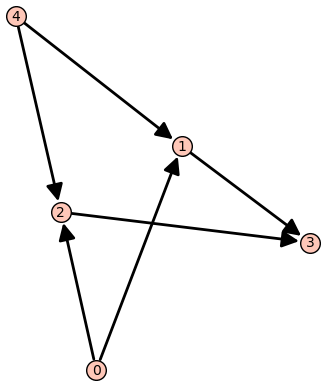

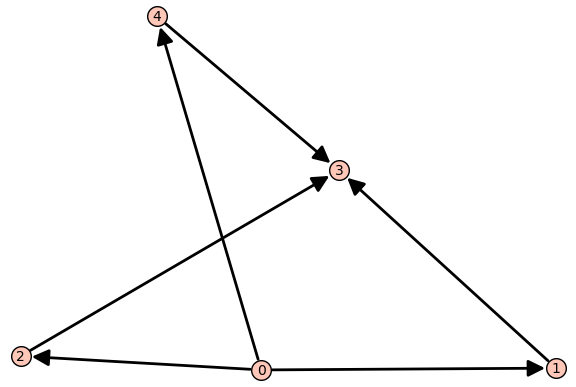

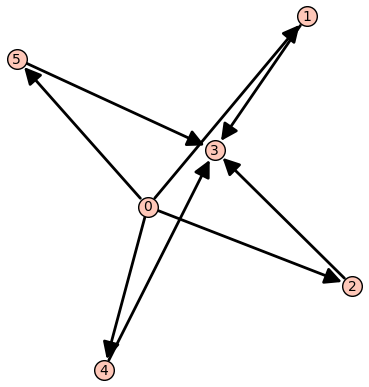

In [11]:
#Square with extra edges so it can be recognized
C4 = DiGraph([[0, 1, 2, 3], [[0, 1], [0, 2], [1, 3], [2, 3]]])
C4_extra=C4.copy()
C4_extra.add_edges([(5,a) for a in [0,1,2,3]]+[(a,5) for a in [0,1,2,3]])

#Forbidden subpatterns
D1=C4.copy()
D1.add_edges([(4,2),(4,1)])
show(D1.plot())
D1.add_edges([(5,a) for a in [0,1,2,3]]+[(a,5) for a in [0,1,2,3]])
D1.add_edges([(6,a) for a in [4,1,2,3]]+[(a,6) for a in [4,1,2,3]])

D2=C4.copy()
D2.add_edges([(0,4),(4,3)])
show(D2.plot())
D2.add_edges([(5,a) for a in [0,1,2,3]]+[(a,5) for a in [0,1,2,3]])
D2.add_edges([(6,a) for a in [0,1,4,3]]+[(a,6) for a in [0,1,4,3]])
D2.add_edges([(7,a) for a in [0,2,4,3]]+[(a,7) for a in [0,2,4,3]])

D3=DiGraph([[0,1],[0,4],[1,3],[4,3],[0,5],[5,3],[0,2],[2,3],[4,3]])
show(D3.plot())
D3.add_edges([(6,a) for a in [0, 1, 4, 3]]+[(a,6) for a in [0, 1, 4, 3]])
D3.add_edges([(7,a) for a in [0, 1, 5, 3]]+[(a,7) for a in [0, 1, 5, 3]])
D3.add_edges([(8,a) for a in [0, 2, 4, 3]]+[(a,8) for a in [0, 2, 4, 3]])
D3.add_edges([(9,a) for a in [0, 2, 5, 3]]+[(a,9) for a in [0, 2, 5, 3]])

# Running the Computations

In [12]:
Possible_Graphs=generate_1_skeletons(7)
Possible_Complexes=generate_2_skeletons(Possible_Graphs,forbidden_patterns=[D1,D2,D3])

In [13]:
#Filter isomorphic Complexes
Possible_Complexes_filtered=[]
Possible_Complexes_as_Graphs=[]
for G, squares in Possible_Complexes:
    G2=G.copy()
    for i,square in enumerate(squares):
        G2.add_edges([(10+i,a) for a in square])
        G2.add_edges([(a,10+i) for a in square])
    if not already_included(G2,Possible_Complexes_as_Graphs):
        Possible_Complexes_as_Graphs.append(G2)
        Possible_Complexes_filtered.append((G,squares))
Possible_Complexes=Possible_Complexes_filtered

In [14]:
len(Possible_Complexes)

7

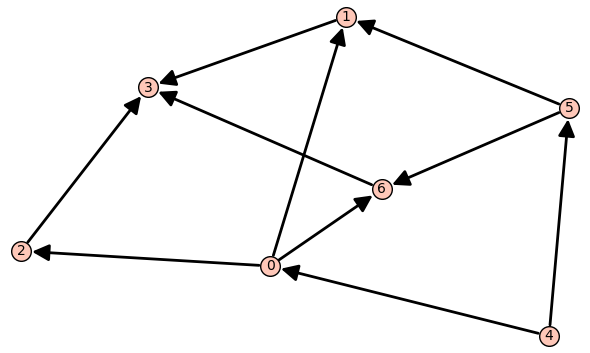

([0, 1, 2, 3], [0, 2, 6, 3], [4, 0, 5, 1], [4, 0, 5, 6], [5, 1, 6, 3])


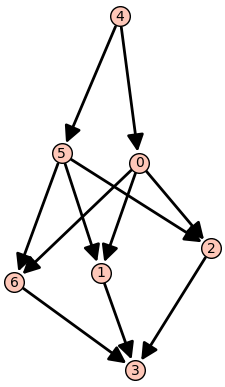

([0, 1, 2, 3], [0, 1, 6, 3], [4, 0, 5, 2], [4, 0, 5, 6], [5, 2, 6, 3])


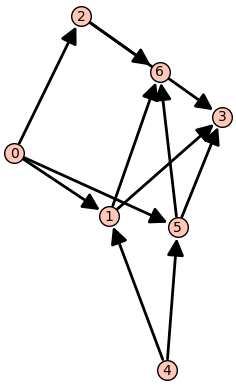

([0, 1, 2, 3], [0, 1, 2, 6], [0, 2, 5, 3], [0, 2, 5, 6], [4, 1, 5, 3], [4, 1, 5, 6])


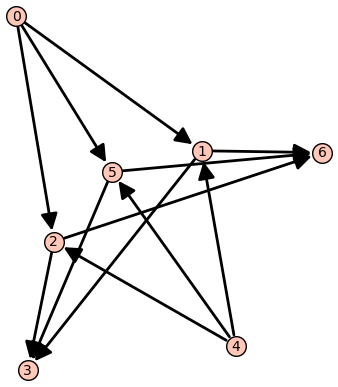

([0, 1, 2, 3], [0, 1, 2, 6], [0, 1, 5, 3], [0, 1, 5, 6], [4, 2, 5, 3], [4, 2, 5, 6])


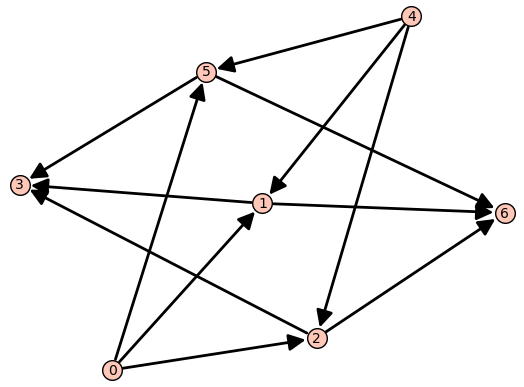

([0, 1, 2, 3], [0, 1, 5, 3], [0, 2, 5, 6], [4, 1, 2, 6], [4, 1, 5, 6], [4, 2, 5, 3])


In [18]:
for G,squares in Possible_Complexes:
    n_comp=count_inserted_symbols(G,squares)
    if n_comp>1:
        show(G.plot())
        print(squares)